# Face Morphing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.path import Path
from scipy.spatial import Delaunay
from a5utils import bilinear_interpolate

# For displaying animations in notebook
from IPython.display import HTML
from a5utils import display_movie

# Transforming Triangles

In [2]:
def get_transform(pts_source,pts_target):
    """
    This function takes the coordinates of 3 points (corners of a triangle)
    and a target position and estimates the affine transformation needed
    to map the source to the target location.
    
    
    Parameters
    ----------
    pts_source : 2D float array of shape 2x3
         Source point coordinates
    pts_target : 2D float array of shape 2x3
         Target point coordinates
   
    Returns
    -------
    T : 2D float array of shape 3x3
        the affine transformation
    """
    
    assert(pts_source.shape==(2,3))
    assert(pts_target.shape==(2,3))
    
    # Homogenous Matrix for pts_source
    A = np.vstack((pts_source, np.ones(pts_source.shape[1])))
    
    # Homogenous Matrix for pts_target
    B = np.vstack((pts_target, np.ones(pts_target.shape[1])))
    
    # Inverse of 'A'
    A_inv = np.linalg.inv(A)
    
    # Compute Affine Transformation Matrix 'T'
    T = B.dot(A_inv)
    
    return T


def apply_transform(T,pts):
    """
    This function takes the coordinates of a set of points and
    a 3x3 transformation matrix T and returns the transformed
    coordinates
    
    
    Parameters
    ----------
    T : 2D float array of shape 3x3
         Transformation matrix
    pts : 2D float array of shape 2xN
         Set of points to transform
   
    Returns
    -------
    pts_warped : 2D float array of shape 2xN
        Transformed points
    """

    assert(T.shape==(3,3))
    assert(pts.shape[0]==2)
    
    # convert to homogenous coordinates, multiply by T, convert back
    A = np.vstack((pts, np.ones(pts.shape[1])))
    B = T.dot(A)
    pts_warped = B[:-1,:]
    
    return pts_warped

# Piecewise Affine Warping

In [4]:
def warp(image,pts_source,pts_target,tri):
    
    """
    This function takes a color image, a triangulated set of keypoints
    over the image, and a set of target locations for those points.
    The function performs piecewise affine wapring by warping the 
    contents of each triangle to the desired target location and 
    returns the resulting warped image.
    
    Parameters
    ----------
    image : 3D float array of shape HxWx3
         An array containing a color image
    
    pts_src: 2D float array of shape 2xN
        Coordinates of N points in the image
        
    pts_target: 2D float array of shape 2xN
        Coorindates of the N points after warping
        
    tri: 2D int array of shape Ntrix3
        The indices of the pts belonging to each of the Ntri triangles
        
    Returns
    -------
    warped_image : 3D float array of shape HxWx3
        resulting warped image
    
    tindex : 2D int array of shape HxW
        array with values in 0...Ntri-1 indicating which triangle 
        each pixel was contained in (or -1 if the pixel is not in any triangle)
    """   

    assert(image.shape[2]==3) #this function only works for color images
    assert(tri.shape[1]==3)   #each triangle has 3 vertices
    assert(pts_source.shape==pts_target.shape)
    assert(np.max(image)<=1)  #image should be float with RGB values in 0..1
    
    ntri = tri.shape[0]
    (h,w,d) = image.shape
    
    # for each pixel in the target image, figure out which triangle
    # it fall inside of so we know which transformation to use for
    # those pixels.
    #
    # tindex[i,j] should contain a value in 0..ntri-1 indicating which
    # triangle contains pixel (i,j).  set tindex[i,j]=-1 if (i,j) doesn't
    # fall inside any triangle
    tindex = -1*np.ones((h,w))
    xx,yy = np.mgrid[0:h,0:w]
    pcoords = np.stack((yy.flatten(),xx.flatten()),axis=1)
    for t in range(ntri):
        corners = pts_target[:,tri[t,:]]  #get vertices of triangle t.
        mask = Path(corners.T).contains_points(pcoords) #create a boolean array where mask[i]=True if pcoords[i] is in the triangle
        mask = mask.reshape(h,w)
        #set tindex[i,j]=t any where that mask[i,j]=True
        tindex[mask==True] = t
        
    # compute the affine transform associated with each triangle that
    # maps a given target triangle back to the source coordinates
    
    xx,yy = np.mgrid[0:h,0:w]
    pix = np.stack((yy.flatten(),xx.flatten()),axis=1)
    Xsource = np.zeros((2,h*w))  #source coordinate for each output pixel
    tindex_flat = tindex.flatten() #flattened version of tindex as an h*w length vector
 
    for t in range(ntri):
        #coordinates of target/output vertices of triangle t
        ptarg = pts_target[:,tri[t,:]]
        
        #coordinates of source/input vertices of triangle t
        psrc = pts_source[:,tri[t,:]]
        
        #compute transform from ptarg -> psrc
        T = get_transform(pts_target[:,tri[t,:]],pts_source[:,tri[t,:]])
        
        #extract coordinates of all the pixels where tindex==t
        pcords = pix[tindex_flat==t,:].transpose()
        
        #store the transformed coordinates at the corresponding locations in Xsource
        Xsource[:,tindex_flat==t] = apply_transform(T,pcords)
    
    # use interpolation to figure out the color values at locations Xsource     
    warped_image = np.zeros(image.shape)
    warped_image[:,:,0] = bilinear_interpolate(image[:,:,0], Xsource[0,:], Xsource[1,:]).reshape(h,w)
    warped_image[:,:,1] = bilinear_interpolate(image[:,:,1], Xsource[0,:], Xsource[1,:]).reshape(h,w)
    warped_image[:,:,2] = bilinear_interpolate(image[:,:,2], Xsource[0,:], Xsource[1,:]).reshape(h,w)
    
    # clip RGB values outside the range [0,1] to avoid warning messages
    warped_image = np.clip(warped_image,0.,1.)

    return (warped_image,tindex)

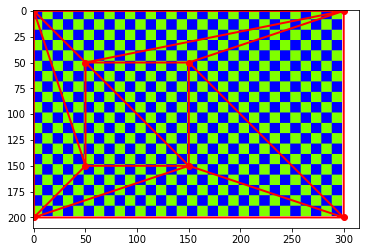

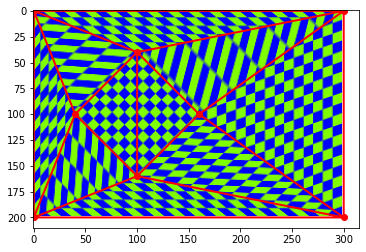

<Figure size 298x198 with 0 Axes>

In [5]:
# Test

#make a color checkerboard image
(xx,yy) = np.mgrid[1:200,1:300]
G = np.mod(np.floor(xx/10)+np.floor(yy/10),2)
B = np.mod(np.floor(xx/10)+np.floor(yy/10)+1,2)
image = np.stack((0.5*G,G,B),axis=2)

#coordinates of the image corners
pts_corners = np.array([[0,300,300,0],[0,0,200,200]])

#points on a square in the middle + image corners
pts_source = np.array([[50,150,150,50],[50,50,150,150]])
pts_source = np.concatenate((pts_source,pts_corners),axis=1)

#points on a diamond in the middle + image corners
pts_target = np.array([[100,160,100,40],[40,100,160,100]])
pts_target = np.concatenate((pts_target,pts_corners),axis=1)

#compute triangulation using mid-point between source and
#target to get triangles that are good for both.
pts_mid = 0.5*(pts_target+pts_source)
trimesh = Delaunay(pts_mid.transpose())
#we only need the vertex indices so extract them from 
#the data structure returned by Delaunay
tri = trimesh.simplices.copy()

# display initial image
plt.imshow(image)
plt.triplot(pts_source[0,:],pts_source[1,:],tri,color='r',linewidth=2)
plt.plot(pts_source[0,:],pts_source[1,:],'ro')
plt.show()

# display warped image
(warped,tindex) = warp(image,pts_source,pts_target,tri)
plt.imshow(warped)
plt.triplot(pts_target[0,:],pts_target[1,:],tri,color='r',linewidth=2)
plt.plot(pts_target[0,:],pts_target[1,:],'ro')
plt.show()

# display animated movie by warping to weighted averages 
# of pts_source and pts_target

#assemble an array of image frames
movie = []
for t in np.arange(0,1,0.1):
    pts_warp = (1-t)*pts_source+t*pts_target
    warped_image,tindex = warp(image,pts_source,pts_warp,tri)
    movie.append(warped_image)

#use display_movie function defined in a5utils.py to create an animation
HTML(display_movie(movie).to_jshtml())

# Face Morphing

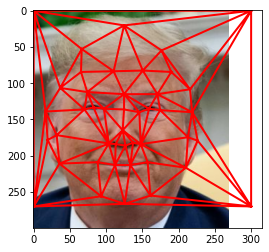

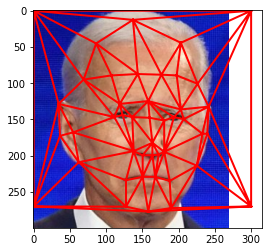

<Figure size 270x300 with 0 Axes>

In [6]:
# load in the keypoints and images select_keypoints.ipynb
f = open('face_correspondeces.pckl','rb')
image1,image2,pts1,pts2 = pickle.load(f)
f.close()

# add the image corners as additional points so that the
# triangles cover the whole image
corners1 = np.array([[0,0], [0, image1.shape[1]],[image1.shape[0], 0], [image1.shape[0], image1.shape[1]]]).T
corners2 = np.array([[0,0], [0, image2.shape[1]],[image2.shape[0], 0], [image2.shape[0], image2.shape[1]]]).T
pts1 = np.hstack((pts1, corners1))
pts2 = np.hstack((pts2, corners2))

#compute triangulation using mid-point between source and
#target to get triangles that are good for both.
pts_mid = 0.5*(pts1+pts2)
trimesh = Delaunay(pts_mid.transpose())
#we only need the vertex indices so extract them from 
#the data structure returned by Delaunay
tri = trimesh.simplices.copy()

# generate the frames of the morph
movie = []
for t in np.arange(0,1,0.05):
    pts_warp = (1-t)*pts1+t*pts2
    warped_image1,tindex1 = warp(image1[:,:,:-1],pts1,pts_warp,tri)
    warped_image2,tindex2 = warp(image2[:,:,:-1],pts2,pts_warp,tri)
    blended_image= (1-t)*warped_image1+t*warped_image2
    movie.append(blended_image)

# display original images and overlaid triangulation
plt.imshow(image1)
plt.triplot(pts1[0,:],pts1[1,:],tri,color='r',linewidth=2)
plt.show()

plt.imshow(image2)
plt.triplot(pts2[0,:],pts2[1,:],tri,color='r',linewidth=2)
plt.show()

# display as an animated movie
HTML(display_movie(movie).to_jshtml())